In [2]:
%load_ext autoreload
%autoreload 2
# %%
import sys
from os.path import join
import torch
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from torchvision import transforms as T
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
from core.model_load_utils import load_model_transform, MODEL_LAYER_FILTERS, LAYER_ABBREVIATION_MAPS
from neural_regress.sklearn_torchify_lib import SRP_torch, PCA_torch, LinearRegression_torch, SpatialAvg_torch
from circuit_toolkit.layer_hook_utils import featureFetcher_module, featureFetcher, get_module_names
from horama import maco, plot_maco

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

outputroot = r"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_models"
subject_id = "red_20250428-20250430"
modelname = "resnet50_robust"
figdir = join(outputroot, subject_id, "model_outputs_trials_denoising_features")
Xdict_prune = pkl.load(open(join(figdir, f"{subject_id}_{modelname}_population_best_layer_Xfeatures.pkl"), "rb"))
dimred = Xdict_prune["dimred"]
layer = Xdict_prune["layer"]
Xtfmer_loaddir = join(outputroot, subject_id, f"model_outputs_pca4all")
Xtfmer_path = join(Xtfmer_loaddir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl")
Xtfmer_pkl = pkl.load(open(Xtfmer_path, "rb"))
Xtransform_layer = Xtfmer_pkl[(layer, dimred)]

# Example to convert sklearn model to torch model
linreg = RidgeCV(alphas=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9], 
                            alpha_per_target=True,)
linreg.fit(Xdict_prune["features"], np.random.randn(Xdict_prune["features"].shape[0], 64))
readout = torch.nn.Linear(Xdict_prune["features"].shape[1], 64)
readout.weight.data = torch.from_numpy(linreg.coef_).float()
readout.bias.data = torch.from_numpy(linreg.intercept_).float()
readout.eval().to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/n/home12/binxuwang/Github/circuit_toolkit/circuit_toolkit/GAN_invert_utils.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


Linear(in_features=750, out_features=64, bias=True)

In [3]:
readout

Linear(in_features=750, out_features=64, bias=True)

In [4]:
Xtransform_layer

PCA(n_components=750)

### Demo run 

$$
W_{ols}W_{PCA}(f(x)-\mu)+b_{ols}=W_{ols}W_{PCA}f(x)-W_{ols}W_{PCA}\mu+b_{ols}
$$

In [31]:
Xtransform = PCA_torch(Xtransform_layer, device=device)
PCA_comp = Xtransform_layer.components_
PCA_mean = Xtransform_layer.mean_
PCA_comp_th = torch.from_numpy(PCA_comp).float().cuda()
PCA_mean_th = torch.from_numpy(PCA_mean).float().cuda()
print(PCA_comp_th.shape, PCA_mean_th.shape)
linreg_weight = readout.weight.data.detach()
linreg_bias = readout.bias.data.detach()
print(linreg_weight.shape, linreg_bias.shape)

torch.Size([750, 100352]) torch.Size([1, 100352])
torch.Size([64, 750]) torch.Size([64])


In [32]:
eff_weight = linreg_weight @ PCA_comp_th
eff_bias = linreg_bias - linreg_weight @ PCA_comp_th @ PCA_mean_th[0]
eff_layer = torch.nn.Linear(PCA_comp_th.shape[1], linreg_bias.shape[0]).cuda()
eff_layer.weight.data = eff_weight
eff_layer.bias.data = eff_bias
print(eff_weight.shape, eff_bias.shape)
# test the eff_weight and eff_bias
test_input = torch.randn(5, PCA_comp_th.shape[1]).cuda()
test_output = test_input @ eff_weight.T + eff_bias.T
test_output_layer = eff_layer(test_input)
print(test_output.shape)
pca_output = readout(Xtransform(test_input))
print(torch.allclose(test_output, test_output_layer))
print(torch.allclose(test_output, pca_output))

torch.Size([64, 100352]) torch.Size([64])
torch.Size([5, 64])
True
True


In [29]:
eff_weight.shape

torch.Size([64, 100352])

In [35]:
eff_weight_tsr = eff_weight.reshape(64, 2048, 7, 7) # [n_neurons, n_channels, H, W] 

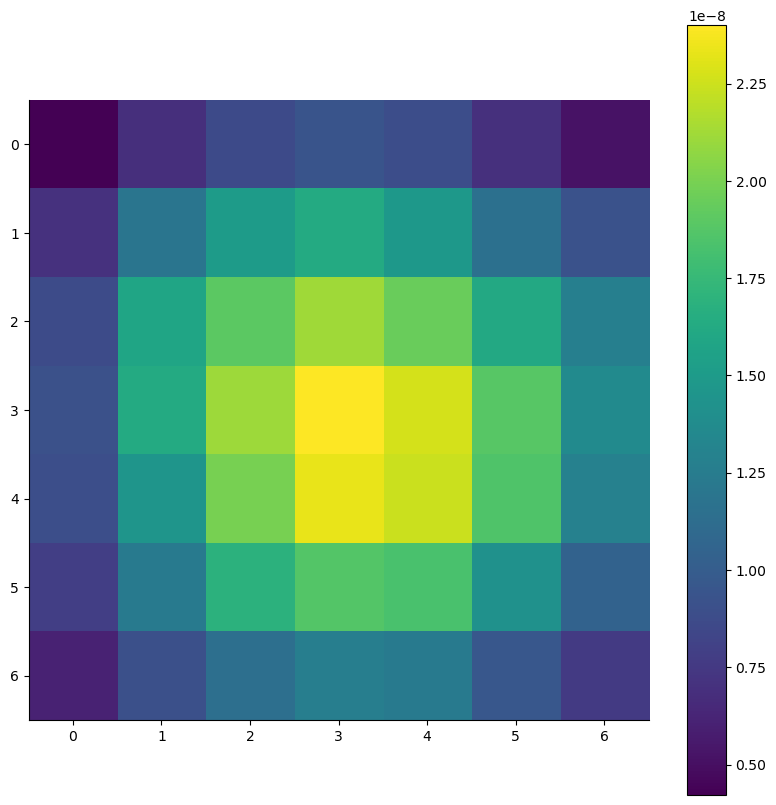

In [41]:
plt.figure(figsize=(10, 10))
plt.imshow(eff_weight_tsr[1:2].abs().mean(dim=[0,1]).cpu().numpy())
plt.colorbar()
plt.show()

In [44]:
# decompose the weight matrix via one sided NMF 
Wtsr = eff_weight_tsr[0]
Wmat = Wtsr.view(Wtsr.shape[0], -1)
Wmat.shape

torch.Size([2048, 49])

In [121]:
import numpy as np
from sklearn.decomposition import NMF

def one_sided_nmf(M, n_components, init='nndsvd', solver='cd', print_eval=True,
                  random_state=None, **nmf_kwargs):
    """
    Compute a semi-NMF of M ≈ W @ H, with W >= 0 but H unconstrained,
    by solving a standard two-sided NMF on [M_pos | M_neg].

    Parameters
    ----------
    M : array-like, shape (n_samples, n_features)
        Input data matrix (may contain negatives).
    n_components : int
        Number of latent components (k).
    init : {'random', 'nndsvd', ...}, optional (default='random')
        Initialization method for NMF.
    solver : {'cd', 'mu'}, optional
        Numerical solver to use in sklearn's NMF.
    random_state : int, RandomState instance or None
        Seed for reproducibility.
    **nmf_kwargs :
        Additional keyword arguments passed to sklearn.decomposition.NMF
        (e.g. max_iter, tol).

    Returns
    -------
    W : ndarray, shape (n_samples, n_components)
        Non-negative basis matrix.
    H : ndarray, shape (n_components, n_features)
        (Possibly mixed-sign) coefficient matrix.

    Notes
    -----
    M is split into its positive and negative parts:
        M_pos = max(M, 0),  M_neg = max(-M, 0),
    stacked as [M_pos | M_neg], then NMF([M_pos | M_neg]) gives
        [M_pos | M_neg] ≈ W @ [H_pos | H_neg],  H = H_pos - H_neg.
    """
    M = np.asarray(M)
    # 1) split into positive and negative parts
    M_pos = np.maximum(M, 0)
    M_neg = np.maximum(-M, 0)

    # 2) stack them side by side
    M_aug = np.concatenate([M_pos, M_neg], axis=1)

    # 3) run two-sided NMF
    model = NMF(n_components=n_components,
                init=init,
                solver=solver,
                random_state=random_state,
                **nmf_kwargs)
    W = model.fit_transform(M_aug)   # shape (n_samples, k)
    H_aug = model.components_        # shape (k, 2*m)
    # 4) recover mixed-sign H
    m = M.shape[1]
    H_pos = H_aug[:, :m]
    H_neg = H_aug[:, m:]
    H = H_pos - H_neg
    # explained variance and contribution from each component
    if print_eval:
        total_var = (M**2).sum()
        cum_W_comp = 0
        for i_comp in range(W.shape[1]):
            W_1comp = W[:, i_comp:i_comp+1] @ H[i_comp:i_comp+1, :]
            cum_W_comp += W_1comp
            residual = (M - W_1comp)
            residual_var = (residual**2).sum()
            print(f"Component {i_comp} explains {100*(1-residual_var/total_var):.2f}% of the total variance")

        residual_var = (M - cum_W_comp)**2
        print(f"The residual variance is {100*(1-residual_var.sum()/total_var):.2f}% of the total variance")
    return W, H

In [122]:
Hvecs, featvecs = one_sided_nmf(Wmat.T.cpu().numpy(), n_components=3, max_iter=1000, random_state=42)

Component 0 explains 30.56% of the total variance
Component 1 explains 21.23% of the total variance
Component 2 explains 18.39% of the total variance
The residual variance is 62.66% of the total variance


In [89]:
total_var = (Wmat**2).sum()
cum_W_comp = 0
for i_comp in range(Hvecs.shape[1]):
    W_1comp = Hvecs[:, i_comp:i_comp+1] @ featvecs[i_comp:i_comp+1, :]
    cum_W_comp += W_1comp
    residual = (Wmat.T.cpu() - W_1comp)
    residual_var = (residual**2).sum()
    print(f"Component {i_comp} explains {100*(1-residual_var/total_var):.2f}% of the total variance")

residual_var = (Wmat.T.cpu() - cum_W_comp)**2
print(f"The residual variance is {100*(1-residual_var.sum()/total_var):.2f}% of the total variance")

Component 0 explains 30.56% of the total variance
Component 1 explains 21.23% of the total variance
Component 2 explains 18.39% of the total variance
The residual variance is 62.66% of the total variance


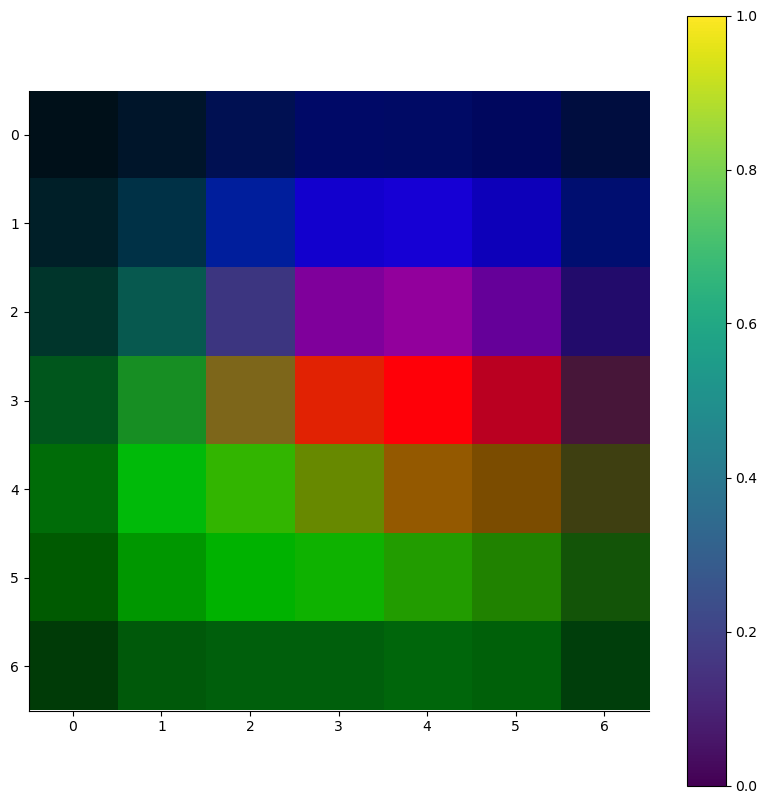

In [90]:
Hmaps = Hvecs.reshape(7, 7, -1)[:, :, :3]
plt.figure(figsize=(10, 10))
plt.imshow(Hmaps / Hmaps.max())
plt.colorbar()
plt.show()

In [91]:
featvecs.shape

(3, 2048)

In [92]:
# Example of running MACO on regression model
model, _ = load_model_transform(modelname, device=device)
normalizer = T.Compose([
    T.Resize(size=(224, 224), antialias=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
fetcher.record(layer,  ingraph=True, store_device=device)
Xtransform = PCA_torch(Xtransform_layer, device=device)


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [93]:
maco_hyperparams = dict(total_steps=500, learning_rate=0.5, image_size=512,
        model_input_size=224, noise=0.01, values_range=(0, 1),
        crops_per_iteration=2, box_size=(0.20, 0.25),)

In [111]:
featvecs_th = torch.from_numpy(featvecs).float().cuda()
Hmaps_th = torch.from_numpy(Hmaps).float().cuda()
eff_bias_th = eff_bias.float().cuda()

In [113]:
from functools import partial

In [115]:
def factorized_objective(images, comp_idx=0):
    # Forward pass through the feature extractor
    images = normalizer(images)
    model(images)
    feat_tsr = fetcher[layer]  # Access the layer4 feature
    chann_multi = torch.einsum("BCHW,kC->BkHW", feat_tsr, featvecs_th[comp_idx:comp_idx+1,:])
    spacial_multi = torch.einsum("BkHW,HWk->Bk", chann_multi, Hmaps_th[:,:,comp_idx:comp_idx+1])
    return spacial_multi.mean()

100%|██████████| 500/500 [00:05<00:00, 98.69it/s]


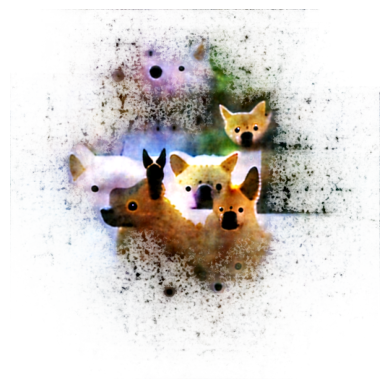

In [116]:
image1, alpha1 = maco(partial(factorized_objective, comp_idx=2), **maco_hyperparams, device='cuda')
plot_maco(image1, alpha1)
plt.show()

### Together

In [137]:
tsr_shape = (2048, 7, 7)
Xtransform = PCA_torch(Xtransform_layer, device=device)
PCA_comp = Xtransform_layer.components_
PCA_mean = Xtransform_layer.mean_
PCA_comp_th = torch.from_numpy(PCA_comp).float().cuda()
PCA_mean_th = torch.from_numpy(PCA_mean).float().cuda()
print(PCA_comp_th.shape, PCA_mean_th.shape)
linreg_weight = readout.weight.data.detach()
linreg_bias = readout.bias.data.detach()
print(linreg_weight.shape, linreg_bias.shape)
eff_weight = linreg_weight @ PCA_comp_th
eff_bias = linreg_bias - linreg_weight @ PCA_comp_th @ PCA_mean_th[0]
eff_layer = torch.nn.Linear(PCA_comp_th.shape[1], linreg_bias.shape[0]).cuda()
eff_layer.weight.data = eff_weight
eff_layer.bias.data = eff_bias
print(eff_weight.shape, eff_bias.shape)
# test the eff_weight and eff_bias
test_input = torch.randn(5, PCA_comp_th.shape[1]).cuda()
test_output = test_input @ eff_weight.T + eff_bias.T
test_output_layer = eff_layer(test_input)
print(test_output.shape)
pca_output = readout(Xtransform(test_input))
print(torch.allclose(test_output, test_output_layer))
print(torch.allclose(test_output, pca_output))
eff_weight_tsr = eff_weight.reshape(-1, *tsr_shape) # [n_neurons, n_channels, H, W] 
# flatten the spatial dimension

torch.Size([750, 100352]) torch.Size([1, 100352])
torch.Size([64, 750]) torch.Size([64])
torch.Size([64, 100352]) torch.Size([64])
torch.Size([5, 64])
True
False


Component 0 explains 32.92% of the total variance
Component 1 explains 18.40% of the total variance
Component 2 explains 29.06% of the total variance
The residual variance is 67.71% of the total variance


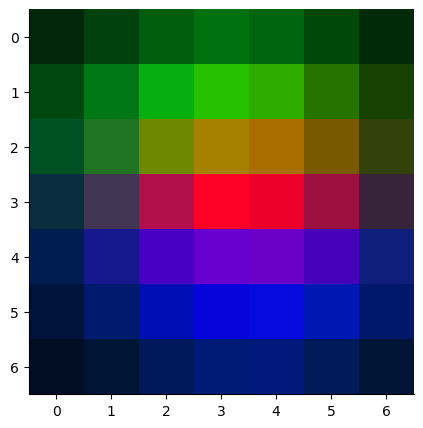

100%|██████████| 500/500 [00:05<00:00, 99.70it/s]


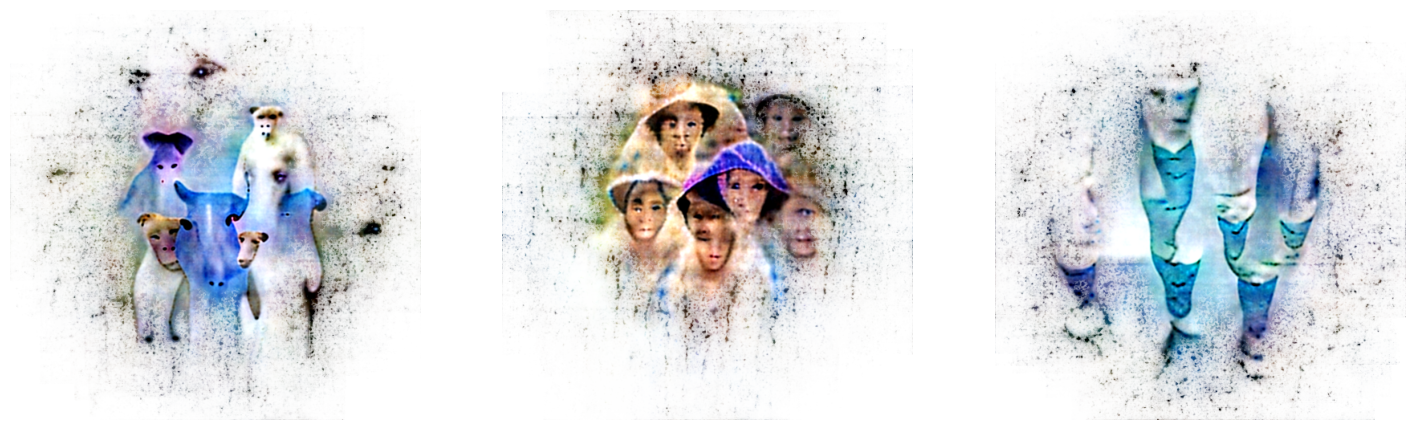

In [144]:
def factorized_objective(images, comp_idx=0):
    # Forward pass through the feature extractor
    images = normalizer(images)
    model(images)
    feat_tsr = fetcher[layer]  # Access the layer4 feature
    chann_multi = torch.einsum("BCHW,kC->BkHW", feat_tsr, featvecs_th[comp_idx:comp_idx+1,:])
    spacial_multi = torch.einsum("BkHW,HWk->Bk", chann_multi, Hmaps_th[:,:,comp_idx:comp_idx+1])
    return spacial_multi.mean()


unit_idx = 47
Wmat = eff_weight_tsr[unit_idx,].flatten(start_dim=1)
Hvecs, featvecs = one_sided_nmf(Wmat.T.cpu().numpy(), n_components=3, max_iter=1000, random_state=42)
Hmaps = Hvecs.reshape(tsr_shape[1], tsr_shape[2], -1)
featvecs_th = torch.from_numpy(featvecs).float().cuda()
Hmaps_th = torch.from_numpy(Hmaps).float().cuda()
eff_bias_th = eff_bias.float().cuda()
plt.figure(figsize=(5, 5))
plt.imshow(Hmaps / Hmaps.max())
plt.show()
plt.figure(figsize=(18, 6.5))
for comp_idx in range(3):
    image1, alpha1 = maco(partial(factorized_objective, comp_idx=comp_idx), **maco_hyperparams, device='cuda')
    plt.subplot(1, 3, comp_idx+1)
    plot_maco(image1, alpha1)
plt.show()

Component 0 explains 27.21% of the total variance
Component 1 explains 17.46% of the total variance
Component 2 explains 22.26% of the total variance
The residual variance is 60.15% of the total variance


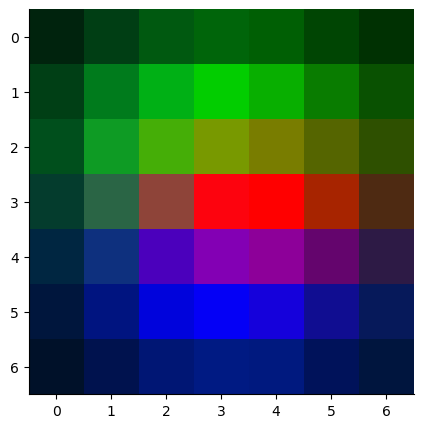

100%|██████████| 500/500 [00:05<00:00, 99.48it/s] 


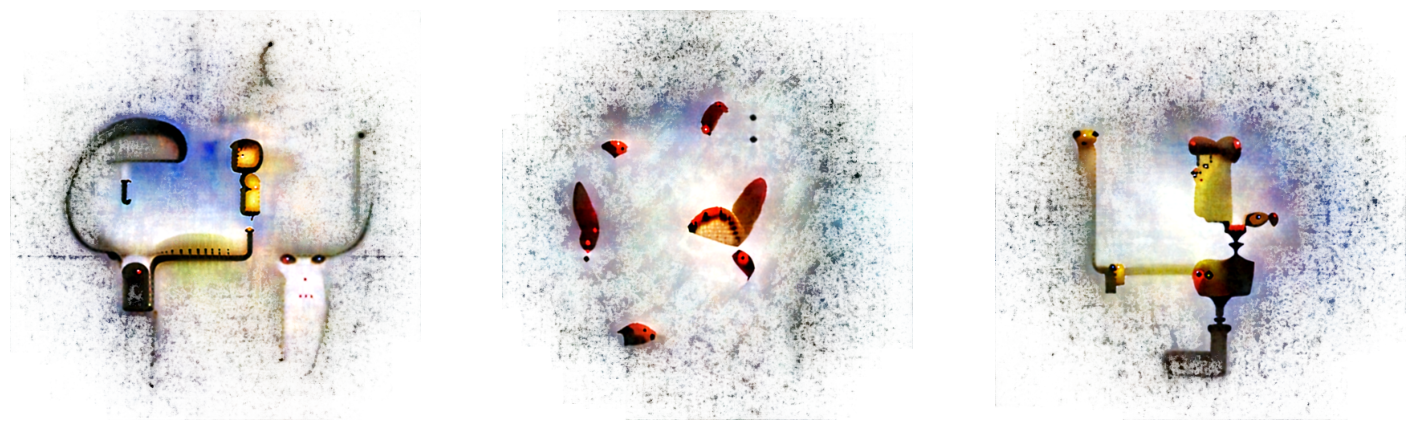

In [141]:
def factorized_objective(images, comp_idx=0):
    # Forward pass through the feature extractor
    images = normalizer(images)
    model(images)
    feat_tsr = fetcher[layer]  # Access the layer4 feature
    chann_multi = torch.einsum("BCHW,kC->BkHW", feat_tsr, featvecs_th[comp_idx:comp_idx+1,:])
    spacial_multi = torch.einsum("BkHW->Bk", chann_multi)
    return spacial_multi.mean()


unit_idx = 1
Wmat = eff_weight_tsr[unit_idx,].flatten(start_dim=1)
Hvecs, featvecs = one_sided_nmf(Wmat.T.cpu().numpy(), n_components=3, max_iter=1000, random_state=42)
Hmaps = Hvecs.reshape(tsr_shape[1], tsr_shape[2], -1)
featvecs_th = torch.from_numpy(featvecs).float().cuda()
Hmaps_th = torch.from_numpy(Hmaps).float().cuda()
eff_bias_th = eff_bias.float().cuda()
plt.figure(figsize=(5, 5))
plt.imshow(Hmaps / Hmaps.max())
plt.show()
plt.figure(figsize=(18, 6.5))
for comp_idx in range(3):
    image1, alpha1 = maco(partial(factorized_objective, comp_idx=comp_idx), **maco_hyperparams, device='cuda')
    plt.subplot(1, 3, comp_idx+1)
    plot_maco(image1, alpha1)
plt.show()

In [ ]:
image1, alpha1 = maco(factorized_objective, **maco_hyperparams, device='cuda')
plot_maco(image1, alpha1)
plt.show()

In [ ]:
# readout = LinearRegression_torch(SKLEARN_MODEL,)
# Define the prediction pipeline
def population_objective(images):
    # Forward pass through the feature extractor
    images = normalizer(images)
    model(images)
    feat_tsr = fetcher[layer]  # Access the layer4 feature
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec).mean(dim=1).mean()

unit_idx = 0
def unit_objective(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer]  # Access the layer4 feature
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)[:, unit_idx].mean()

# check_gradient(objective)
maco_hyperparams = dict(total_steps=500, learning_rate=0.5, image_size=512,
        model_input_size=224, noise=0.01, values_range=(0, 1),
        crops_per_iteration=2, box_size=(0.20, 0.25),)

image1, alpha1 = maco(population_objective, **maco_hyperparams, device='cuda')
plot_maco(image1, alpha1)
plt.show()

image1, alpha1 = maco(unit_objective, **maco_hyperparams, device='cuda')
plot_maco(image1, alpha1)
plt.show()